# Notes on Chapter 3 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
from math import pi
tfd = tfp.distributions
tfm = tf.math

In [2]:
%load_ext rpy2.ipython

### 3.1

In [3]:
%%R

Pr_Positive_Vampire <- 0.95
Pr_Positive_Mortal <- 0.01
Pr_Vampire <- 0.001
Pr_Positive <- Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive <- Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

[1] 0.08683729


There's no advantage to using tensorflow if we're just using python as a calculator, so the python code is virtually identical to the R code:

In [4]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
Pr_Positive = Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

0.08683729433272395

### 3.2

In [5]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prob_p <- rep(1, 1000)
prob_data <- dbinom(6, size=9, prob=p_grid)
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)

In [6]:
p_grid = tf.linspace(0., 1., 1000)
prob_p = tf.ones_like(p_grid)
prob_data = tfd.Binomial(9, probs=p_grid).prob(6)
posterior = prob_data * prob_p
posterior = posterior / tfm.reduce_sum(posterior)

### 3.3

In [7]:
%%R

samples <- sample(p_grid, prob=posterior, size=1e4, replace=TRUE)

In [8]:
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

### 3.4

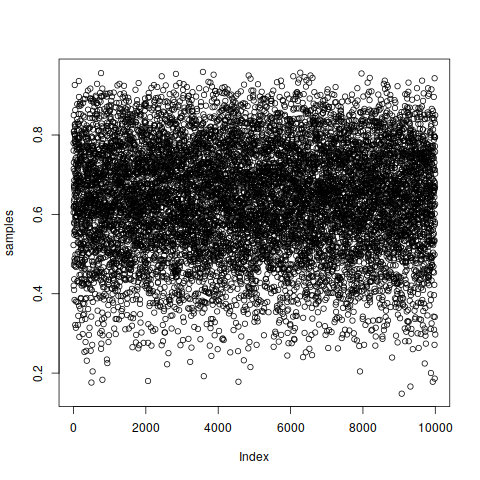

In [9]:
%%R

plot(samples)

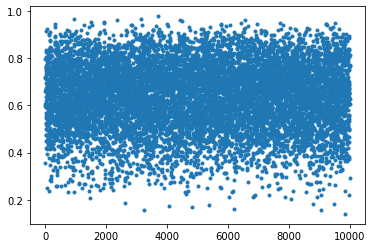

In [10]:
plt.plot(samples, '.');

### 3.5

R[write to console]: Loading required package: rstan

R[write to console]: Loading required package: StanHeaders

R[write to console]: Loading required package: ggplot2

R[write to console]: rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

R[write to console]: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: dagitty

R[write to console]: rethinking (Version 2.01)

R[write to console]: 
Attaching package: ‘rethinking’


R[write to console]: The following object is masked from ‘package:stats’:

    rstudent




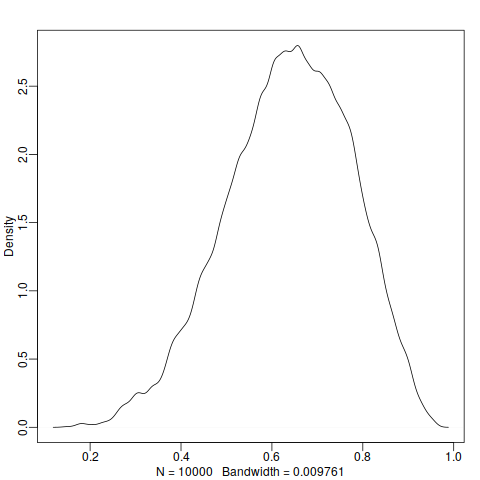

In [11]:
%%R

library(rethinking)
dens(samples)

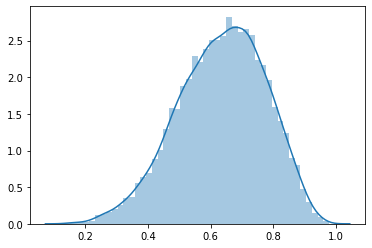

In [12]:
sns.distplot(samples)

### 3.6

In [13]:
%%R

sum(posterior[p_grid < 0.5])

[1] 0.1718746


In [14]:
tf.reduce_sum(posterior[p_grid < 0.5])

<tf.Tensor: shape=(), dtype=float32, numpy=0.17187457>

### 3.7

In [15]:
%%R

sum(samples < 0.5) / 1e4

[1] 0.1653


In [16]:
tf.reduce_sum(tf.cast(samples < 0.5, tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.1747>

### 3.8

In [17]:
%%R

sum(samples > 0.5 & samples < 0.75) / 1e4

[1] 0.6128


In [18]:
tf.reduce_sum(tf.cast(tf.logical_and(samples > 0.5, samples < 0.75), tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.6042>

### 3.9

In [19]:
%%R

quantile(samples, 0.8)

      80% 
0.7597598 


In [20]:
tfp.stats.percentile(samples, 80)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7587587>

### 3.10

In [21]:
%%R

quantile(samples, c(0.1, 0.8))

      10%       80% 
0.4524525 0.7597598 


In [22]:
tfp.stats.percentile(samples, (10, 80))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.44844845, 0.7587587 ], dtype=float32)>

### 3.11

In [23]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1, 1000)
likelihood <- dbinom(3, size=3, prob=p_grid)
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample(p_grid, size=1e4, replace=TRUE, prob=posterior)

In [24]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(3, probs=p_grid).prob(3)
posterior = likelihood * prior
posterior = posterior / tfm.reduce_sum(posterior)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

### 3.12

In [25]:
%%R

PI(samples, prob=0.5)

      25%       75% 
0.7027027 0.9319319 


Since we don't have a python version of the author's library (yet), we have to write our own PI function.

In [26]:
def PI(samples, prob):
    # for performance reasons tensorflow probability only provides an O(n) 
    # approximation of quantiles rather than an O(n log(n)) exact computation
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantile_indexes = tf.cast(
        n_quantiles * tf.constant([(1 - prob)/2, (1 + prob)/2]), tf.int32)
    return tf.gather(all_quantiles, quantile_indexes)

PI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7077077, 0.9319319], dtype=float32)>

### 3.13

In [27]:
%%R

HPDI(samples, prob=0.5)

     |0.5      0.5| 
0.8418418 1.0000000 


Again, we don't have a python version of the author's library, so we have to reimplement the HPDI function.

In [28]:
def HPDI(samples, prob):
    # for performance reasons tensorflow probability only provides an O(n) 
    # approximation of quantiles rather than an O(n log(n)) exact computation
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantiles_per_bin = int(prob * n_quantiles)
    bin_widths = (all_quantiles[quantiles_per_bin:] - 
                  all_quantiles[:-quantiles_per_bin])
    smallest_bin = tfm.argmin(bin_widths)
    return tf.gather(all_quantiles,
                     [smallest_bin, smallest_bin + quantiles_per_bin])

HPDI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8418418, 0.998999 ], dtype=float32)>

### 3.14

In [29]:
%%R

p_grid[which.max(posterior)]

[1] 1


In [30]:
p_grid[tfm.argmax(posterior)]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

### 3.15

In [31]:
%%R
chainmode(samples, adj=0.01)

[1] 0.9917493


This is again one of the author's functions that we don't have a tensorflow equivalent for.  Unfortunately we also don't seem to have a kernel density estimator in tensorflow (on which this function depends).  Rather than using a non-tensorflow implementation of a KDE (e.g. from scipy), we implement a tensorflow version here.

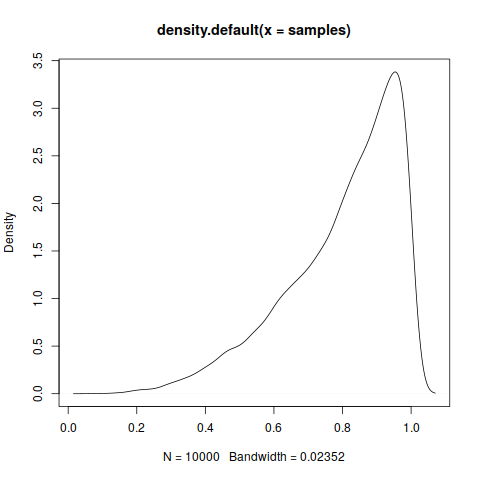

In [32]:
%%R

plot(density(samples), adjust=0.01)

In [33]:
@tf.function()
def kde(samples, adjust=1., n=512):
    quartiles = tfp.stats.quantiles(samples, 4)
    sd = tfp.stats.stddev(samples)
    iqr = quartiles[3]-quartiles[1]
    # Silverman's (1986) rule of thumb:
    bw = adjust*0.9*samples.shape[0]**(1./5)*tf.minimum(iqr/1.34,sd)
    minx = quartiles[0] - 2*bw
    maxx = quartiles[4] + 2*bw
    xs = tf.linspace(minx, maxx, n)
    binned_samples = tf.cast(tf.histogram_fixed_width(
        samples, [minx, maxx], n), dtype=samples.dtype)
    kernels = tfd.Normal(loc=xs,scale=bw).prob(xs[:,tf.newaxis])
    ys = (tf.tensordot(binned_samples, kernels, [[0],[1]]) / samples.shape[0])
    return xs,ys

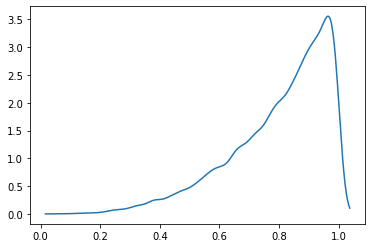

In [34]:
xs,ys = kde(samples, adjust=0.02)
plt.plot(xs,ys)

Now we can implement the chainmode function, and finally the code in the solution.

In [35]:
def chainmode(samples, *args, **nargs):
    xs,ys = kde(samples, *args, **nargs)
    return xs[tfm.argmax(ys)]

In [36]:
chainmode(samples, adjust=0.02)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9633558>

### 3.16

In [37]:
%%R

c(mean(samples),median(samples))

[1] 0.7993023 0.8418418


In [38]:
tfm.reduce_mean(samples), tfp.stats.percentile(samples, 50)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.80102295>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8428428>)

### 3.17

In [39]:
%%R

sum(posterior*abs(0.5 - p_grid))

[1] 0.3128752


In [40]:
tfm.reduce_sum(posterior*abs(0.5 - p_grid))

<tf.Tensor: shape=(), dtype=float32, numpy=0.31287518>

### 3.18

In [41]:
%%R

loss <- sapply(p_grid, function(d) sum(posterior*abs(d - p_grid)))

While tf.map_fn would be closer to sapply, it seems more natural to express it in a vectorized fashion in tensorflow.

In [42]:
loss = tfm.reduce_sum(posterior[:,tf.newaxis]*abs(
    p_grid[tf.newaxis,:] - p_grid[:,tf.newaxis]), axis=0)

### 3.19

In [43]:
%%R

p_grid[which.min(loss)]

[1] 0.8408408


In [44]:
p_grid[tf.argmin(loss)]

<tf.Tensor: shape=(), dtype=float32, numpy=0.8408408>

### 3.20

In [45]:
%%R

dbinom(0:2, size=2, prob=0.7)

[1] 0.09 0.42 0.49


In [46]:
tfd.Binomial(2, probs=0.7).prob(tf.range(3.))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09      , 0.42000002, 0.48999998], dtype=float32)>

### 3.21

In [47]:
%%R

rbinom(1, size=2, prob=0.7)

[1] 0


In [48]:
tfd.Binomial(2, probs=0.7).sample(1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>

### 3.22

In [49]:
%%R

rbinom(10, size=2, prob=0.7)

 [1] 2 1 2 1 2 0 0 1 1 2


In [50]:
tfd.Binomial(2, probs=0.7).sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([2., 1., 2., 1., 2., 2., 0., 1., 1., 1.], dtype=float32)>

### 3.23

In [51]:
%%R

dummy_w <- rbinom(1e5, size=2, prob=0.7)
table(dummy_w)/1e5

dummy_w
      0       1       2 
0.09065 0.41956 0.48979 


In [52]:
num_tosses = 2
dummy_w = tfd.Binomial(num_tosses, probs=0.7).sample(10**5)
tf.reduce_sum(tf.one_hot(tf.cast(dummy_w, tf.int32), num_tosses+1), axis=0) / (
    len(dummy_w) )

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09016, 0.41919, 0.49065], dtype=float32)>

### 3.23

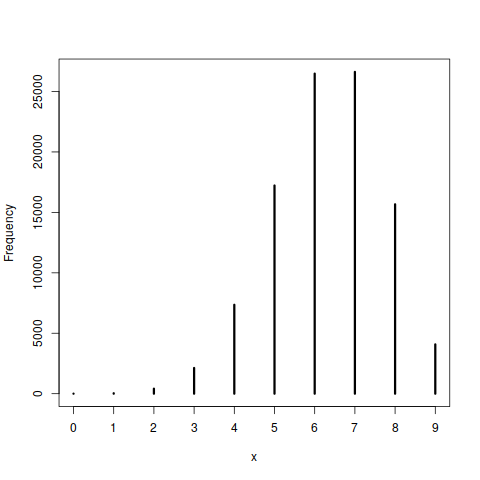

In [53]:
%%R

dummy_w <- rbinom(1e5, size=9, prob=0.7)
simplehist(dummy_w)

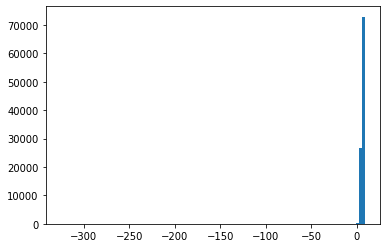

In [54]:
num_tosses = 9
dummy_w = tfd.Binomial(num_tosses, probs=0.7).sample(10**5)
plt.hist(dummy_w, bins=100);

### 3.25

In [55]:
%%R

w <- rbinom(1e4, size=9, prob=0.6)

In [56]:
w = tfd.Binomial(9, probs=0.6).sample(1e4)

### 3.26

In [57]:
%%R

w <- rbinom(1e4, size=9, prob=samples)

In [58]:
w = tfd.Binomial(9, probs=samples).sample()

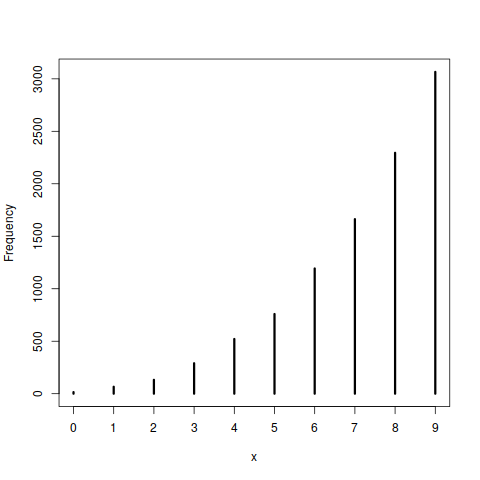

In [59]:
%%R

simplehist(w)

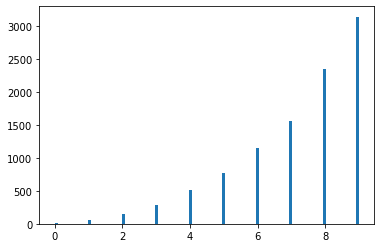

In [60]:
plt.hist(w, bins=100);

### Practice

### 3.27

*NB:* Increased number of samples from $10^4$ to $10^6$ to reduce sampling noise and thus make it easier to compare implementations.

In [61]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1,1000)
likelihood <- dbinom(6, size=9, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)
set.seed(100)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)

In [62]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(9, probs=p_grid).prob(6)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
tf.random.set_seed(100)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))

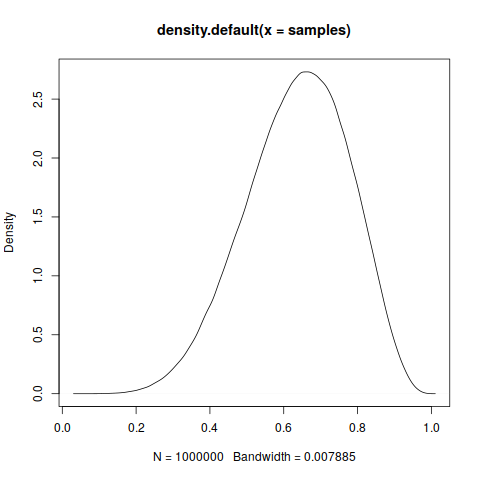

In [63]:
%%R

plot(density(samples))

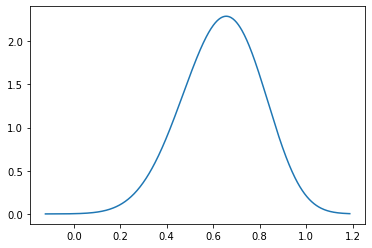

In [64]:
xs,ys = kde(samples, adjust=0.05)
plt.plot(xs,ys);

### 3E1

In [65]:
%%R

sum(samples<0.2)/length(samples)

[1] 0.000871


In [66]:
tf.reduce_sum(tf.cast(samples < 0.2, tf.float32))/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.000879>

### 3E2

In [67]:
%%R

sum(samples > 0.8)/length(samples)

[1] 0.120409


In [68]:
tf.reduce_sum(tf.cast(samples > 0.8, tf.float32))/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.120794>

### 3E3

In [69]:
%%R

sum((samples > 0.2) & (samples < 0.8))/length(samples)

[1] 0.87872


In [70]:
tf.reduce_sum(
    tf.cast(tf.logical_and(samples > 0.2, samples < 0.8), tf.float32)
    )/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.878327>

### 3E4

In [71]:
%%R

quantile(samples, 0.2)

      20% 
0.5165165 


In [72]:
tfp.stats.percentile(samples, 20)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5165165>

### 3E5

In [73]:
%%R

quantile(samples, 0.8)

      80% 
0.7607608 


In [74]:
tfp.stats.percentile(samples, 80)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7607607>

### 3E6

In [75]:
%%R

HPDI(samples, 0.66)

    |0.66     0.66| 
0.5135135 0.7857858 


In [76]:
HPDI(samples, 0.66)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5165165, 0.7887888], dtype=float32)>

### 3E7

In [77]:
%%R

quantile(samples, c(0.17, 0.83))

      17%       83% 
0.4984985 0.7747748 


In [78]:
tfp.stats.percentile(samples, [17, 83])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.4984985, 0.7747748], dtype=float32)>

### 3M1

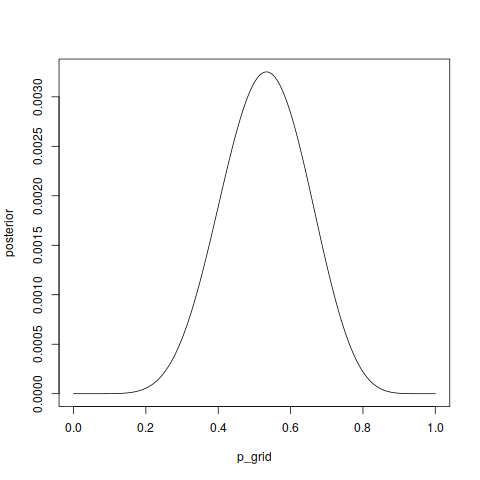

In [79]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1,1000)
likelihood <- dbinom(8, size=15, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)

plot(p_grid, posterior, type="l")

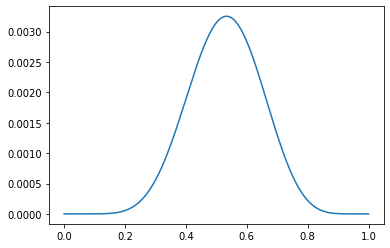

In [81]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(15, probs=p_grid).prob(8)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
plt.plot(p_grid, posterior)

### 3M2

We'll again modify the problem to generate $10^6$ samples (instead of $10^4$) to reduce sampling noise and thus make it easier to compare the python and R implementations.

In [110]:
%%R

set.seed(42)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)
HPDI(samples, 0.9)

     |0.9      0.9| 
0.3293293 0.7167167 


In [111]:
tf.random.set_seed(42)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))
HPDI(samples, 0.9)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.33433434, 0.7207207 ], dtype=float32)>

### 3M3

In [112]:
%%R

prediction_samples = rbinom(n=length(samples), size=15, prob=samples)
sum(prediction_samples == 8) / length(prediction_samples)

[1] 0.146826


In [113]:
prediction_samples = tfd.Binomial(15, probs=samples).sample()
tfm.reduce_mean(tf.cast(prediction_samples == 8, tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=0.1475>

### 3M4

In [114]:
%%R

prediction_samples = rbinom(n=length(samples), size=9, prob=samples)
sum(prediction_samples == 6) / length(prediction_samples)

[1] 0.177008


In [115]:
prediction_samples = tfd.Binomial(9, probs=samples).sample()
tfm.reduce_mean(tf.cast(prediction_samples == 6, tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=0.1768>

### 3M5
#### 3M5.M1

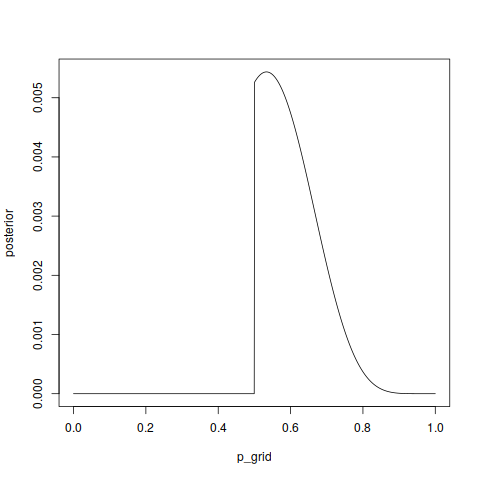

In [116]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- c(rep(0,500), rep(1,500))
likelihood <- dbinom(8, size=15, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)

plot(p_grid, posterior, type="l")

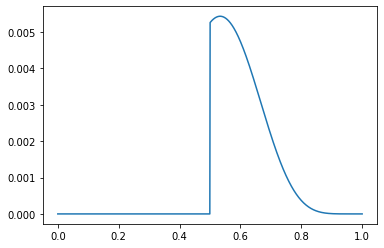

In [119]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.cast(p_grid > 0.5, p_grid.dtype)
likelihood = tfd.Binomial(15, probs=p_grid).prob(8)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
plt.plot(p_grid, posterior)

#### 3M5.M2

We'll again modify the problem to generate $10^6$ samples (instead of $10^4$) to reduce sampling noise and thus make it easier to compare the python and R implementations.

In [120]:
%%R

set.seed(42)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)
HPDI(samples, 0.9)

     |0.9      0.9| 
0.5005005 0.7117117 


In [121]:
tf.random.set_seed(42)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))
HPDI(samples, 0.9)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5005005, 0.7117117], dtype=float32)>

#### 3M5.M3

In [125]:
%%R

prediction_samples = rbinom(n=length(samples), size=15, prob=samples)
print(sum(prediction_samples == 8) / length(prediction_samples))
print(dbinom(8, size=15, prob=0.7))

[1] 0.157599
[1] 0.08113003


In [126]:
prediction_samples = tfd.Binomial(15, probs=samples).sample()
pred = tfm.reduce_mean(tf.cast(prediction_samples == 8, tf.float16))
ideal = tfd.Binomial(15, probs=0.7).prob(8)
print(f'predicted: {pred:.3f}, ideal {ideal:.3f}')

predicted: 0.158, ideal 0.081


### 3M5.M4

In [127]:
%%R

prediction_samples = rbinom(n=length(samples), size=9, prob=samples)
print(sum(prediction_samples == 6) / length(prediction_samples))
print(dbinom(6, size=9, prob=0.7))

[1] 0.232208
[1] 0.2668279


In [128]:
prediction_samples = tfd.Binomial(9, probs=samples).sample()
pred = tfm.reduce_mean(tf.cast(prediction_samples == 6, tf.float16))
ideal = tfd.Binomial(9, probs=0.7).prob(6)
print(f'predicted: {pred:.3f}, ideal {ideal:.3f}')

predicted: 0.232, ideal 0.267
